# 241 Final Project 
# Spectral Clustering
In this project, we seek to group similar datapoints (of non-categorical data) into neighborhood clusters by applying a standard k-means clustering algorithm. To achieve this, we create a similarity matrix and find the first k eigenvectors for the Laplacian matrix, which measures the degree of connectedness of data clusters. Then, we apply k-means to the rows of the Laplacian matrix we generate by subtracting the adjacency matrix from the degree matrix which measures the degree of connections of each node in the graph.

Source: 

In [ ]:
import Pkg;
using LinearAlgebra
using CSV
using DataFrames
using Plots
using Clustering

## Importing and Cleaning Data

In [ ]:
# given url for data, imports it into a matrix. 
# the z column is ignored. it's extraneous information form the data generator. 
import_data(s) = begin
    df = CSV.File(s) |> DataFrame;
    df = select!(df, Not(:z));
    arr = Matrix(df);
    return arr;
end

We decided to scale our data down a little to make the numbers more manageable. 

In [ ]:
preprocess(A) = begin
    A = (0.007)*A
    return A
end

Here are 2 helper functions that plots the data. One will color the plot according to labels. 

In [ ]:
plot_data(A) = begin
    x = A[:,1]
    y = A[:,2]
    display(scatter(x, y, xlims=(-1,7), ylims=(-1,7), aspect_ratio=:equal))
end

plot_data_evecs(A) = begin
    x = A[:,1]
    y = A[:,2]
    display(scatter(x, y, xlims=(-0.25,0.25), ylims=(-0.25,0.25), aspect_ratio=:equal))
end

plot_labeled_data(A, labels) = begin
    x = A[:,1]
    y = A[:,2]
    display(scatter(x, y, c = labels, xlims=(-1,7), ylims=(-1,5), aspect_ratio=:equal))
end

plot_data_evals(A) = begin
    x = 1:5;
    y = A[1:5,1]
    display(scatter(x, y, xlims=(0,6), ylims=(-0.02, 0.03), label = ["First 5 Eigenvalues"], aspect_ratio=:100))
end

## Calculating Similarity Matrix

#### Approach 1: Calculating the Fully Connected Graph with Gaussian Similarity Function

In [ ]:
# Calculates the Gaussian similarity function with parameter e
calc_gaussian(x, y, e) = begin
    res = exp((-((norm((x - y)))^2))/(2*e^2))
    return res
end

# Returns the n x n fully-connected similarity matrix
calc_sim_full(A, e) = begin
    n = size(A, 1)
    R = zeros(Float64, (n, n))
    for i in 1:n
        for j in 1:n
            if(i != j)
                R[i, j] = calc_gaussian(vec(A[i,:]), vec(A[j, :]), e)
            end
        end
    end
    return R
end

#### Approach 2: Calculating the k-nearest neighbor Similarity Matrix

In [ ]:
# Calculates the distance between vectors x and y, squared
calc_distance(x, y) = begin
    return (norm(x - y, 2))^2;
end

# Returns the similarity matrix. 1 if k-nearest neightbor, 0 if not. Note that this is not mutually and thus not symmetric
calc_sim_k(A, k) = begin
    n = size(A, 1)
    R = zeros(Float64, (n, n))
    min = 10000
    min_i = 0
    prev_min = 0
    for i in 1:n
        min = 10000
        min_i = 0
        prev_min = 0
        for a in 1:k
            min = 10000
            for j in 1:n
                if(i != j)
                    d = calc_distance(vec(A[i,:]), vec(A[j, :]))
                    if(d < min && d > prev_min)
                        min_i = j
                        min = d
                    end
                end
            end
            R[i, min_i] = 1
            prev_min = min
        end
    end
    return R
end

## Degree and Laplace Matrix

In [ ]:
# Calculates the degree matrix
calc_D(S) = begin
    n = size(S, 1)
    res = zeros(Float64, (n, n))
    for i in 1:n
        sum = 0
        for j in 1:n
            sum += S[i, j]
        end
        res[i, i] = sum
    end
    return res
end

# Calculates the laplacian from D and W
calc_L(S, D) = begin
    return D - S
end

# Calculates the laplacian from W
calc_LaPlace(A) = begin
    A_d = calc_D(A)
    A_l = calc_L(A, A_d)
    return A_l
end

In [ ]:
# calcualtes the k-means from the eigenvectors and with k clusters
k_means(evec, k) = begin
    R = kmeans(transpose(evec[:,1:k]), k; maxiter=200, display=:iter)
    display(R.centers)
    return R
end

## Putting it All together

In [ ]:
# running spectral clustering on csv at s, with k-neighbors(k = k_1) and k_2 clusters
spectral_clustering_K(s, k_1, k_2) = begin
    A = import_data(s);
    display("Finished Importing Data\n");
    A = preprocess(A)
    plot_data(A)
    
    A_similarity_K = calc_sim_k(A, k_1);
    display("Similarity Matrix\n");
    display(A_similarity_K[1:20,1:5])
    
    A_laplace_K = calc_LaPlace(A_similarity_K)
    display("Laplace Matrix");
    display(A_laplace_K[1:20,1:5])
    
    evals = real.(eigvals(A_laplace_K))
    display("Eigenvalues \n");
    display(evals[1:10])

    evecs = real.(eigvecs(A_laplace_K))
    display("Eigenvectors\n");
    display(evecs[1:20,1:5])
    
    display("Eigenvectors Graph");
    plot_data_evecs(evecs)
    display("Eigenvalues Graph");
    plot_data_evals(evals)

    Kmeans_res = k_means(evecs, k_2)
    plot_labeled_data(A, assignments(Kmeans_res))
end

In [ ]:
# running spectral clustering on csv at s, with fully connected gaussian similarity(sigma = k_1) and k_2 clusters
spectral_clustering_F(s, k_1, k_2) = begin
    A = import_data(s);
    display("Finished Importing Data\n");
    A = preprocess(A)
    plot_data(A)
    
    A_similarity_F = calc_sim_full(A, k_1);
    
    A_laplace_F = calc_LaPlace(A_similarity_F)
    display("Laplace Matrix");
    display(A_laplace_F[1:20,1:5])
    
    evals = real.(eigvals(A_laplace_F))
    display("Eigenvalues \n");
    display(evals[1:10])

    evecs = real.(eigvecs(A_laplace_F))
    display("Eigenvectors\n");
    display(evecs[1:20,1:5])
    
    display("Eigenvectors Graph");
    plot_data_evecs(evecs)
    display("Eigenvalues Graph");
    plot_data_evals(evals)

    Kmeans_res = k_means(evecs, k_2)
    plot_labeled_data(A, assignments(Kmeans_res))
    
end

## Running the Lines Data Set

"Finished Importing Data\n"

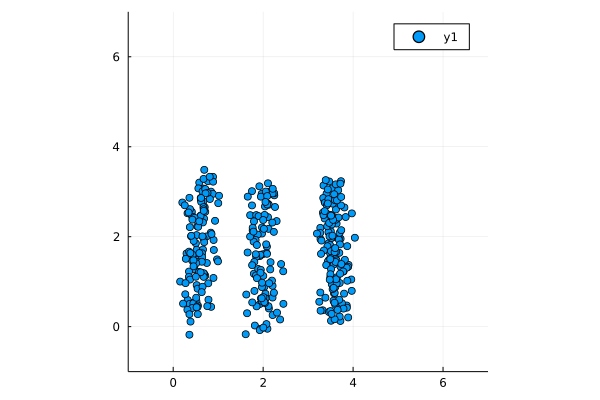

"Similarity Matrix\n"

20×5 Matrix{Float64}:
 0.0  1.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0  0.0
 1.0  1.0  0.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  0.0
 0.0  1.0  0.0  1.0  0.0
 0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  0.0
 1.0  1.0  0.0  1.0  0.0

"Laplace Matrix"

20×5 Matrix{Float64}:
 20.0  -1.0  -1.0  -1.0  -1.0
 -1.0  20.0  -1.0  -1.0   0.0
 -1.0  -1.0  20.0  -1.0  -1.0
  0.0  -1.0   0.0  20.0   0.0
 -1.0  -1.0  -1.0  -1.0  20.0
 -1.0  -1.0  -1.0  -1.0   0.0
 -1.0  -1.0  -1.0  -1.0   0.0
 -1.0  -1.0  -1.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
 -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0   0.0
 -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0   0.0  -1.0   0.0
  0.0  -1.0   0.0  -1.0   0.0
  0.0  -1.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
 -1.0  -1.0  -1.0  -1.0   0.0
 -1.0  -1.0   0.0  -1.0   0.0

"Eigenvalues \n"

10-element Vector{Float64}:
 -7.771561172376096e-16
  3.3306690738754696e-16
  1.3322676295501878e-15
  0.4561296045487133
  0.4570995664803692
  0.5818388661710178
  1.1661457192985294
  1.7819107382258645
  2.384773871857501
  2.8587376736431147

"Eigenvectors\n"

20×5 Matrix{Float64}:
 0.0905357  0.0  0.0  0.114546   0.0
 0.0905357  0.0  0.0  0.113612   0.0
 0.0905357  0.0  0.0  0.114546   0.0
 0.0905357  0.0  0.0  0.106554   0.0
 0.0905357  0.0  0.0  0.114546   0.0
 0.0905357  0.0  0.0  0.111802   0.0
 0.0905357  0.0  0.0  0.110677   0.0
 0.0905357  0.0  0.0  0.113667   0.0
 0.0905357  0.0  0.0  0.102942   0.0
 0.0905357  0.0  0.0  0.113976   0.0
 0.0905357  0.0  0.0  0.113667   0.0
 0.0905357  0.0  0.0  0.114546   0.0
 0.0905357  0.0  0.0  0.114546   0.0
 0.0905357  0.0  0.0  0.114546   0.0
 0.0905357  0.0  0.0  0.111829   0.0
 0.0905357  0.0  0.0  0.108189   0.0
 0.0905357  0.0  0.0  0.107086   0.0
 0.0905357  0.0  0.0  0.0940459  0.0
 0.0905357  0.0  0.0  0.114043   0.0
 0.0905357  0.0  0.0  0.112206   0.0

"Eigenvectors Graph"

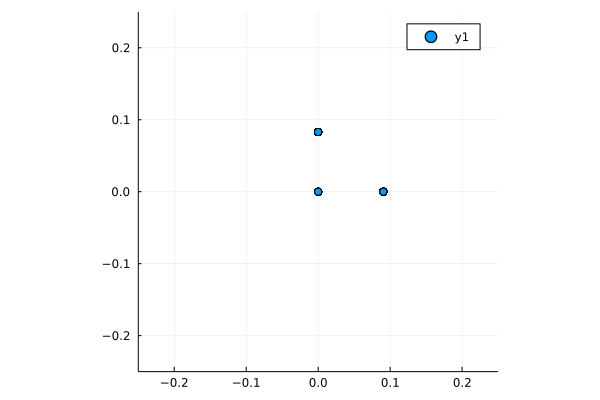

"Eigenvalues Graph"

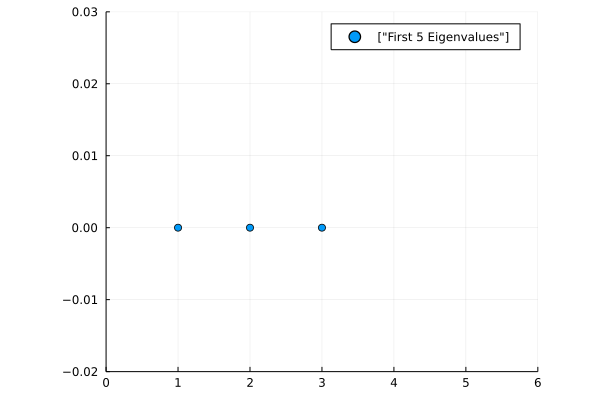

3×3 Matrix{Float64}:
  0.0        0.0905357  0.0
  0.0        0.0        0.0830455
 -0.0995037  0.0        0.0

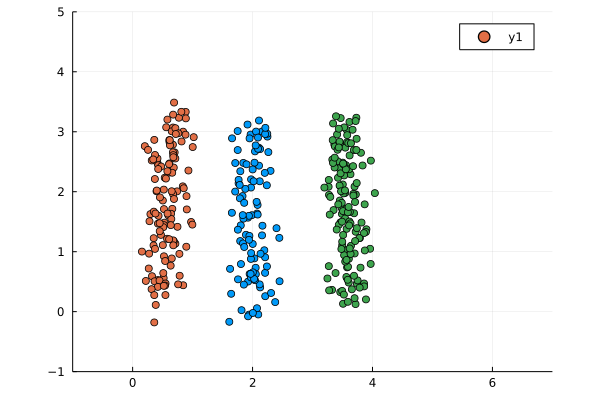

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       6.938894e-17
      1       8.673617e-17       1.734723e-17 |        0
K-means converged with 1 iterations (objv = 8.673617379884035e-17)


In [26]:
spectral_clustering_K("./data/lines.csv", 20, 3)

"Finished Importing Data\n"

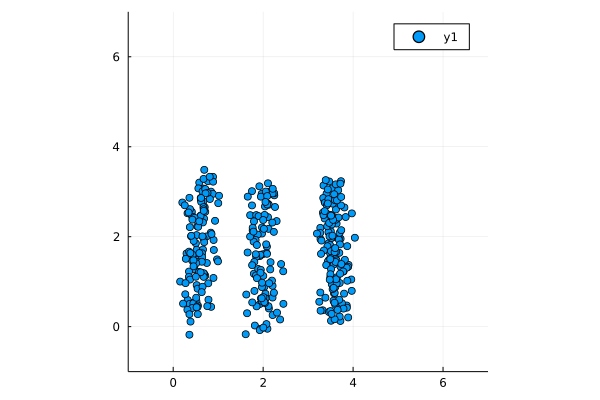

"Laplace Matrix"

20×5 Matrix{Float64}:
  2.67074      -0.0525475    -0.329677     -2.52814e-5   -0.0296721
 -0.0525475     3.35687      -0.00401381   -0.0224681    -2.49576e-6
 -0.329677     -0.00401381    1.82159      -3.44618e-8   -0.0454514
 -2.52814e-5   -0.0224681    -3.44618e-8    4.99932      -1.99486e-11
 -0.0296721    -2.49576e-6   -0.0454514    -1.99486e-11   0.366945
 -0.010011     -0.812614     -0.000740479  -0.0273394    -9.6415e-8
 -0.000246985  -0.136804     -5.74797e-5   -0.00109833   -2.76541e-10
 -0.161109     -0.188875     -0.00355282   -0.0169102    -0.000171412
 -2.39234e-7   -3.83113e-6   -2.11548e-11  -0.00597283   -1.7194e-11
 -0.15211      -0.00432762   -0.00424435   -0.000106869  -0.0096248
 -0.0299221    -0.0145897    -0.000192063  -0.00814645   -8.71131e-5
 -0.551348     -0.00447814   -0.100638     -3.65006e-6   -0.130283
 -0.509315     -0.0775997    -0.558239     -6.61307e-6   -0.004499
 -0.565705     -0.0039667    -0.767529     -1.12858e-7   -0.147034
 -0.0380293    -0.168

"Eigenvalues \n"

10-element Vector{Float64}:
 -3.8425454617099913e-16
  1.7148842268082412e-15
  2.7960913085249328e-11
  0.006676326131240342
  0.010100216357270382
  0.012925803095759041
  0.014579384360082277
  0.02155510645345347
  0.03256265314866066
  0.03358895420544913

"Eigenvectors\n"

20×5 Matrix{Float64}:
 -0.0111381  -0.0660316  -0.0609302  3.13402e-10  0.0938478
 -0.0111381  -0.0660316  -0.0609302  3.21959e-10  0.0898508
 -0.0111381  -0.0660316  -0.0609302  3.16661e-10  0.0950585
 -0.0111381  -0.0660316  -0.0609302  2.5735e-10   0.0850511
 -0.0111381  -0.0660316  -0.0609302  3.2015e-10   0.0970722
 -0.0111381  -0.0660316  -0.0609302  3.41854e-10  0.0898333
 -0.0111381  -0.0660316  -0.0609302  5.33427e-10  0.0911638
 -0.0111381  -0.0660316  -0.0609302  3.015e-10    0.0900638
 -0.0111381  -0.0660316  -0.0609302  1.97606e-10  0.0813295
 -0.0111381  -0.0660316  -0.0609302  3.06231e-10  0.0921125
 -0.0111381  -0.0660316  -0.0609302  2.98782e-10  0.090242
 -0.0111381  -0.0660316  -0.0609302  3.12397e-10  0.0939035
 -0.0111381  -0.0660316  -0.0609302  3.16462e-10  0.0944747
 -0.0111381  -0.0660316  -0.0609302  3.15997e-10  0.0949072
 -0.0111381  -0.0660316  -0.0609302  2.96145e-10  0.089246
 -0.0111381  -0.0660316  -0.0609302  3.07193e-10  0.0880695
 -0.0111381  -0.0660

"Eigenvectors Graph"

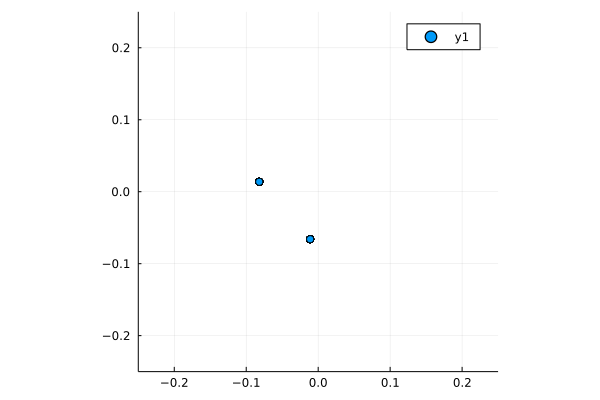

"Eigenvalues Graph"

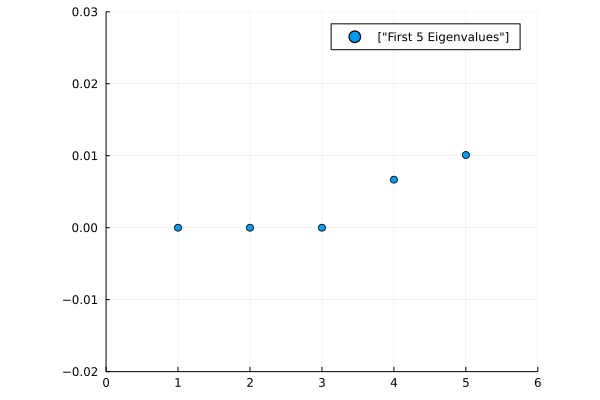

3×3 Matrix{Float64}:
 -0.0111387  -0.0818886   -0.0111381
 -0.0660328   0.0138131   -0.0660316
  0.0735975  -2.46623e-7  -0.0609302

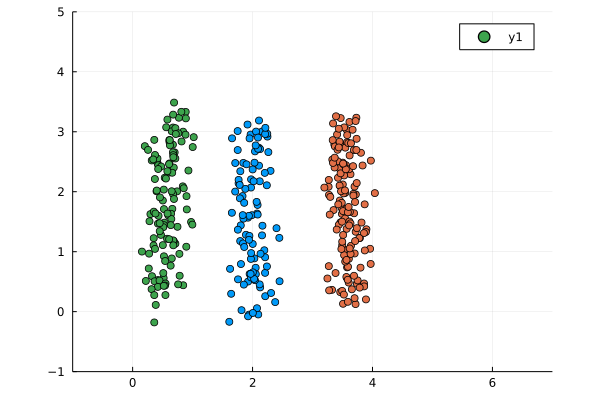

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       9.887924e-17
      1       1.266348e-16       2.775558e-17 |        0
K-means converged with 1 iterations (objv = 1.2663481374630692e-16)


In [27]:
spectral_clustering_F("./data/lines.csv", 0.1, 3)

"Finished Importing Data\n"

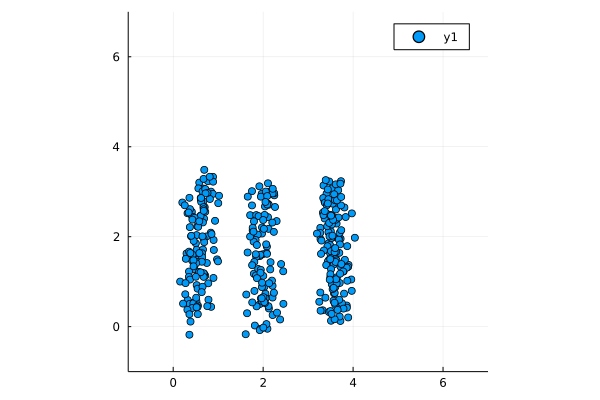

"Laplace Matrix"

20×5 Matrix{Float64}:
  1.95439e-25   -1.13555e-128  -6.43877e-49    0.0           -1.71737e-153
 -1.13555e-128   9.73666e-10   -2.26801e-240  -1.43427e-165   0.0
 -6.43877e-49   -2.26801e-240   3.23224e-12    0.0           -5.68545e-135
  0.0           -1.43427e-165   0.0            4.33898e-6     0.0
 -1.71737e-153   0.0           -5.68545e-135   0.0            5.51781e-84
 -1.11574e-200  -9.73665e-10   -8.93898e-314  -4.77361e-157   0.0
  0.0           -4.07362e-87    0.0           -1.18354e-296   0.0
 -5.15289e-80   -4.14351e-73   -1.14118e-245  -6.52825e-178   0.0
  0.0            0.0            0.0           -4.1495e-223    0.0
 -1.64303e-82   -4.21658e-237  -6.04148e-238   0.0           -2.18356e-202
 -3.97318e-153  -2.53921e-184   0.0           -1.24981e-209   0.0
 -1.38864e-26   -1.28745e-235  -1.88818e-100   0.0           -3.08189e-89
 -4.99628e-30   -9.68286e-112  -4.80859e-26    0.0           -2.04923e-235
 -1.81548e-25   -6.96525e-241  -3.23224e-12    0.0           -5.5177

"Eigenvalues \n"

10-element Vector{Float64}:
 -2.9708913398250075e-16
 -1.9819124547585795e-16
 -1.7084932266898892e-16
 -1.5998634025796112e-16
 -1.447976766452989e-16
 -1.3839242405493556e-16
 -1.12771493865967e-16
 -8.615700981482443e-17
 -8.217617870513618e-17
 -6.79099074725875e-17

"Eigenvectors\n"

20×5 Matrix{Float64}:
  1.39626e-271   1.57223e-81   0.0   3.98367e-61   -2.09967e-63
 -1.80816e-198  -8.08242e-18   0.0   0.0154502     -5.68231e-7
  3.32582e-308   1.58992e-109  0.0  -4.79066e-59    5.66827e-80
 -1.59555e-131   0.000302536   0.0   0.0186832     -0.165764
  0.0            5.46317e-178  0.0  -2.04895e-128   1.08644e-148
  1.12185e-207   1.10441e-22   0.0   0.0154503     -5.67631e-7
 -2.8526e-252    1.41115e-62   0.0  -9.93604e-32   -2.44557e-37
  1.60966e-193   2.97887e-13   0.0  -0.00614574     0.000134534
  4.74274e-234  -1.40675e-99   0.0  -1.18709e-89    2.86566e-94
 -3.30226e-249  -1.07431e-64   0.0  -1.68477e-36    5.86336e-44
  1.79851e-212  -7.34294e-36   0.0   4.16194e-15   -2.19357e-17
  6.40734e-284  -2.83289e-95   0.0   7.00999e-57    7.34339e-69
 -4.44484e-301   4.05289e-107  0.0   3.53245e-73    1.05285e-82
 -1.6151e-296    1.3092e-102   0.0   4.79066e-59    3.76903e-78
 -7.59586e-184  -6.88537e-17   0.0  -0.00614574     0.000134528
  4.64801e-183  -7.187

"Eigenvectors Graph"

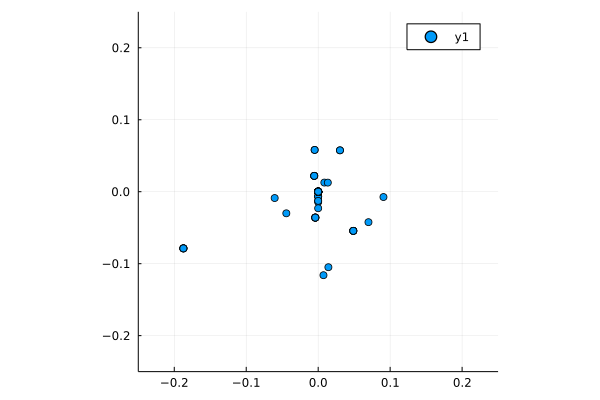

"Eigenvalues Graph"

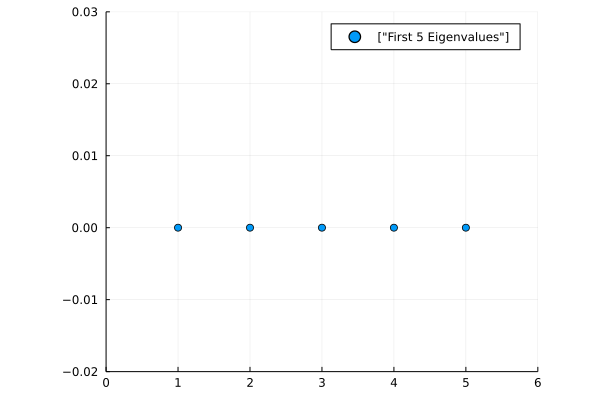

3×3 Matrix{Float64}:
 -0.00520219   0.530561     -0.0442636
 -0.00607037  -0.0620219    -0.0300286
 -0.00411983   5.00169e-33   0.351993

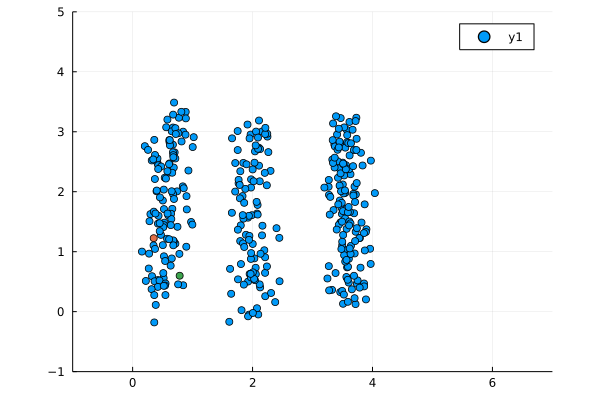

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.587899e+00
      1       2.558295e+00      -2.960397e-02 |        0
      2       2.558295e+00       0.000000e+00 |        0
K-means converged with 2 iterations (objv = 2.5582946283027397)


In [28]:
spectral_clustering_F("./data/lines.csv", 0.01, 3)

"Finished Importing Data\n"

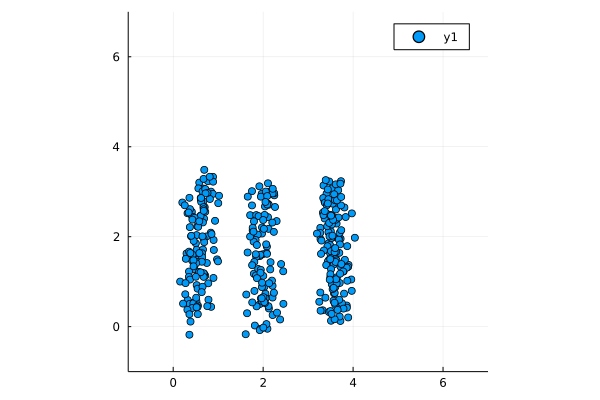

"Laplace Matrix"

20×5 Matrix{Float64}:
 71.5018    -0.970969  -0.988965  -0.899556  -0.965436
 -0.970969  85.0904    -0.946315  -0.962755  -0.878966
 -0.988965  -0.946315  67.8982    -0.842119  -0.969562
 -0.899556  -0.962755  -0.842119  91.6208    -0.781626
 -0.965436  -0.878966  -0.969562  -0.781626  56.5786
 -0.955003  -0.997927  -0.930454  -0.964646  -0.850827
 -0.920294  -0.980305  -0.906975  -0.93413   -0.802449
 -0.981909  -0.983471  -0.945161  -0.960023  -0.916939
 -0.858595  -0.882741  -0.782085  -0.950084  -0.780466
 -0.981345  -0.947027  -0.946843  -0.912617  -0.954627
 -0.965517  -0.958607  -0.917983  -0.953037  -0.910753
 -0.994064  -0.947351  -0.977299  -0.882314  -0.979826
 -0.993276  -0.974762  -0.994187  -0.887573  -0.947395
 -0.994319  -0.946203  -0.997358  -0.852168  -0.981012
 -0.967835  -0.982337  -0.923876  -0.975368  -0.890924
 -0.923705  -0.986404  -0.883539  -0.988185  -0.804004
 -0.909904  -0.960178  -0.849985  -0.997454  -0.803058
 -0.760417  -0.7923    -0.673523  -0.896087  

"Eigenvalues \n"

10-element Vector{Float64}:
 -2.984279490192421e-13
 20.704647377461754
 37.6133175820501
 42.53201991825429
 49.62426706894439
 54.04749352464587
 55.413730058625084
 58.01335142435027
 58.681486075771865
 61.50198182841849

"Eigenvectors\n"

20×5 Matrix{Float64}:
 -0.0521286  -0.0659065  -0.0865562  -0.0566733  0.0756272
 -0.0521286  -0.0595469  -0.0658749  -0.0396804  0.0465006
 -0.0521286  -0.0643195  -0.0937973  -0.0646723  0.0844795
 -0.0521286  -0.0619333  -0.0565161  -0.0307205  0.0389901
 -0.0521286  -0.0766321  -0.133259   -0.102381   0.205886
 -0.0521286  -0.0576238  -0.0620206  -0.0368626  0.041595
 -0.0521286  -0.0527058  -0.0574158  -0.0343429  0.0344834
 -0.0521286  -0.0658242  -0.0748376  -0.0456121  0.0606818
 -0.0521286  -0.0717038  -0.0692207  -0.0385768  0.0582174
 -0.0521286  -0.0714769  -0.0906998  -0.0583748  0.0874204
 -0.0521286  -0.0693379  -0.0787595  -0.0479228  0.0683627
 -0.0521286  -0.0704     -0.0963931  -0.0644911  0.0955493
 -0.0521286  -0.0617808  -0.0818982  -0.0538627  0.065623
 -0.0521286  -0.066947   -0.0967774  -0.0664961  0.0922249
 -0.0521286  -0.0653679  -0.070629   -0.041957   0.0555222
 -0.0521286  -0.0583269  -0.0568576  -0.0320877  0.0374031
 -0.0521286  -0.0640076  -0.0600507  

"Eigenvectors Graph"

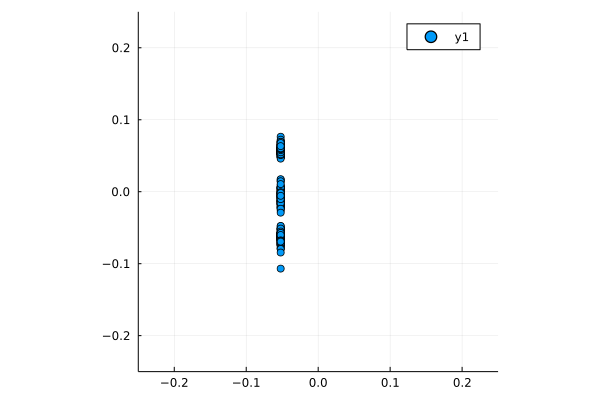

"Eigenvalues Graph"

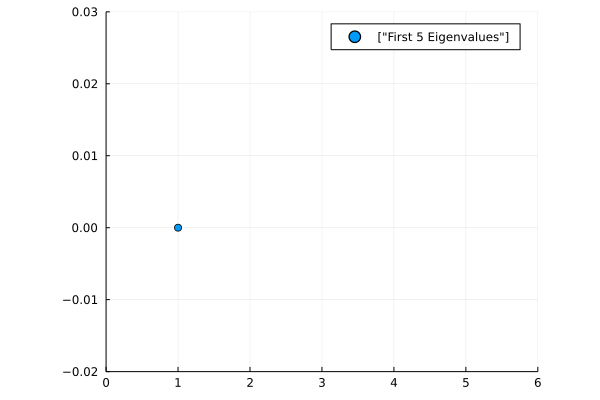

3×3 Matrix{Float64}:
 -0.0521286  -0.0521286  -0.0521286
 -0.0402024  -0.03588     0.0561798
 -0.0313119   0.054639    0.000812157

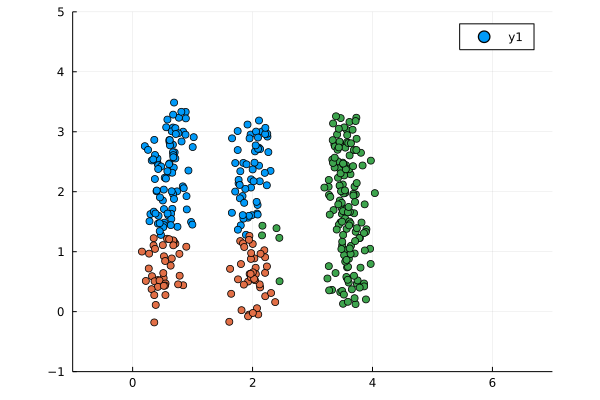

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       9.896130e-01
      1       8.459357e-01      -1.436772e-01 |        3
      2       8.311227e-01      -1.481306e-02 |        3
      3       8.298095e-01      -1.313174e-03 |        2
      4       8.297667e-01      -4.282058e-05 |        2
      5       8.297150e-01      -5.171223e-05 |        2
      6       8.296634e-01      -5.156549e-05 |        0
      7       8.296634e-01       0.000000e+00 |        0
K-means converged with 7 iterations (objv = 0.8296633962588232)


In [29]:
spectral_clustering_F("./data/lines.csv", 1, 3)

"Finished Importing Data\n"

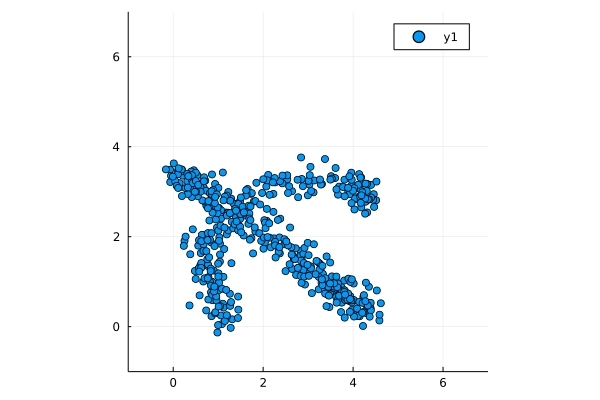

"Similarity Matrix\n"

20×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

"Laplace Matrix"

20×5 Matrix{Float64}:
 20.0   0.0   0.0   0.0   0.0
  0.0  20.0  -1.0  -1.0   0.0
  0.0  -1.0  20.0   0.0   0.0
  0.0   0.0   0.0  20.0   0.0
  0.0  -1.0  -1.0   0.0  20.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0

"Eigenvalues \n"

10-element Vector{Float64}:
 -2.914335439641036e-16
  0.018290138838023356
  0.029671842477621512
  0.17595534049870457
  0.38149125667857026
  0.5123209637212897
  1.5761316275261588
  1.695341313007288
  1.7220683900509932
  2.2981233252168614

"Eigenvectors\n"

20×5 Matrix{Float64}:
 0.0443678  0.020828   -0.0431654  0.128212    0.0638273
 0.0443678  0.0206374  -0.0425155  0.116791    0.0516748
 0.0443678  0.0207355  -0.0428537  0.122724    0.057924
 0.0443678  0.0204531  -0.0418653  0.105498    0.0401883
 0.0443678  0.0206897  -0.042691   0.119845    0.0549217
 0.0443678  0.0204445  -0.04182    0.104613    0.0393362
 0.0443678  0.02035    -0.0414613  0.0983843   0.0333795
 0.0443678  0.0202935  -0.041244   0.0946625   0.0299211
 0.0443678  0.02035    -0.0414613  0.0983843   0.0333795
 0.0443678  0.0202801  -0.0412034  0.0940508   0.0293394
 0.0443678  0.0203297  -0.0414175  0.0979115   0.0329023
 0.0443678  0.0199995  -0.0400901  0.0750263   0.0123498
 0.0443678  0.0200902  -0.0404337  0.0805527   0.0172693
 0.0443678  0.0198383  -0.0394243  0.063236    0.00242669
 0.0443678  0.019838   -0.03943    0.0633493   0.00237698
 0.0443678  0.0197829  -0.0391546  0.0573919  -0.00154133
 0.0443678  0.0199044  -0.0396836  0.0675359   0.00613082
 0.044

"Eigenvectors Graph"

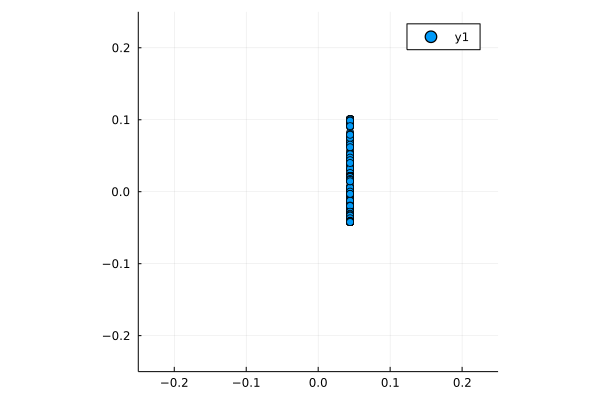

"Eigenvalues Graph"

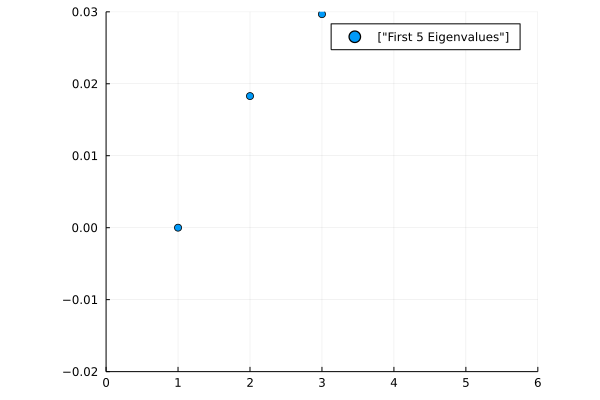

2×2 Matrix{Float64}:
  0.0443678   0.0443678
 -0.00150068  0.0879735

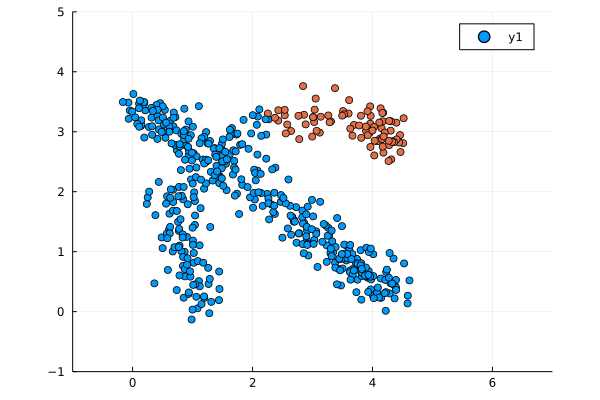

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       6.754479e-01
      1       3.496443e-01      -3.258035e-01 |        2
      2       3.489698e-01      -6.745729e-04 |        2
      3       3.489406e-01      -2.919883e-05 |        0
      4       3.489406e-01       0.000000e+00 |        0
K-means converged with 4 iterations (objv = 0.3489405757845292)


In [30]:
spectral_clustering_K("./data/communism.csv", 20, 2)

"Finished Importing Data\n"

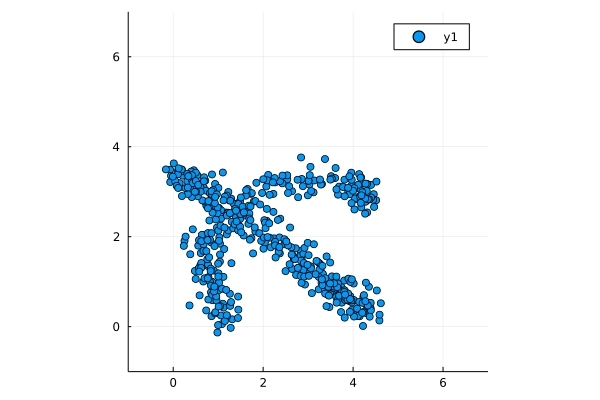

"Similarity Matrix\n"

20×5 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

"Laplace Matrix"

20×5 Matrix{Float64}:
 15.0   0.0   0.0   0.0   0.0
  0.0  15.0  -1.0   0.0   0.0
  0.0  -1.0  15.0   0.0   0.0
  0.0   0.0   0.0  15.0   0.0
  0.0  -1.0  -1.0   0.0  15.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0

"Eigenvalues \n"

10-element Vector{Float64}:
 1.5364574042242464e-15
 0.007982688013186244
 0.01576242328403938
 0.06218674327780635
 0.1792680015430255
 0.25976625171394224
 0.739986733837807
 0.8174551282980524
 0.9114497698432384
 1.110049875783542

"Eigenvectors\n"

20×5 Matrix{Float64}:
 -0.0443678  0.0465331  -0.0285981  -0.125307   -0.0404762
 -0.0443678  0.0461347  -0.0281149  -0.116996   -0.0328343
 -0.0443678  0.0463562  -0.0283834  -0.121601   -0.0370352
 -0.0443678  0.0457743  -0.0276793  -0.109651   -0.0264472
 -0.0443678  0.0462805  -0.0282917  -0.120035   -0.0356367
 -0.0443678  0.045731   -0.0276266  -0.108759   -0.0257443
 -0.0443678  0.0455761  -0.0274397  -0.10565    -0.0231629
 -0.0443678  0.0454121  -0.0272417  -0.102389   -0.0206101
 -0.0443678  0.0455761  -0.0274397  -0.10565    -0.0231629
 -0.0443678  0.0450539  -0.0268091  -0.095273   -0.0151313
 -0.0443678  0.0454818  -0.0273266  -0.103825   -0.0217118
 -0.0443678  0.044216   -0.0257962  -0.0786365  -0.00262827
 -0.0443678  0.0441665  -0.0257344  -0.0775201  -0.00183507
 -0.0443678  0.0431193  -0.024464   -0.0565214   0.0134182
 -0.0443678  0.0431293  -0.0244808  -0.057001    0.0133384
 -0.0443678  0.0430403  -0.0243693  -0.0550226   0.0145107
 -0.0443678  0.0432994  -0.02468

"Eigenvectors Graph"

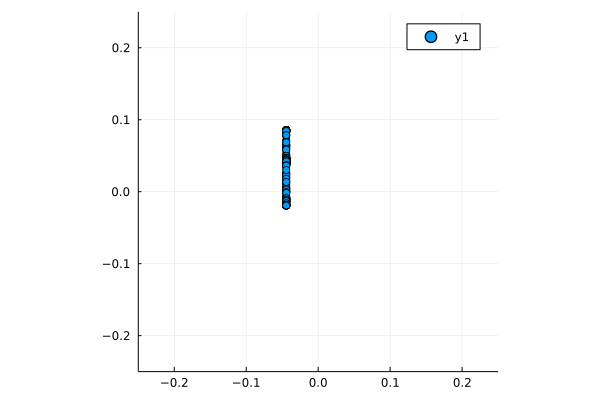

"Eigenvalues Graph"

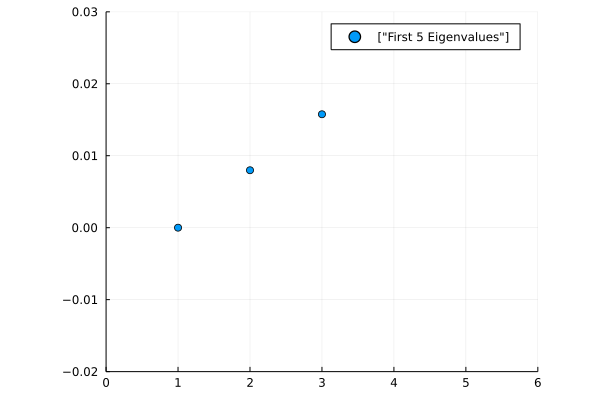

2×2 Matrix{Float64}:
 -0.0443678  -0.0443678
 -0.0128027   0.0506379

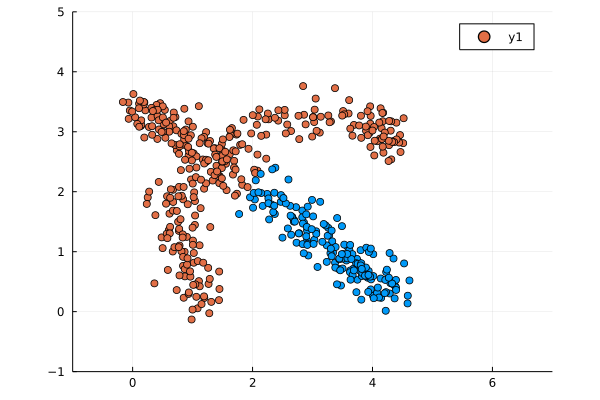

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.582581e-01
      1       1.079045e-01      -5.035368e-02 |        2
      2       1.078471e-01      -5.733754e-05 |        2
      3       1.078382e-01      -8.875387e-06 |        0
      4       1.078382e-01       0.000000e+00 |        0
K-means converged with 4 iterations (objv = 0.10783824383153057)


In [31]:
spectral_clustering_K("./data/communism.csv", 15, 2)

"Finished Importing Data\n"

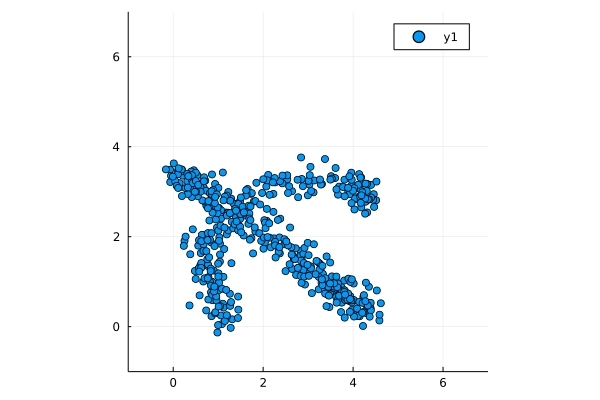

"Laplace Matrix"

20×5 Matrix{Float64}:
 17.5569       -0.174198     -0.429131     -0.0112077    -0.0500396
 -0.174198     22.5063       -0.839032     -0.518122     -0.175099
 -0.429131     -0.839032     20.9732       -0.220365     -0.220909
 -0.0112077    -0.518122     -0.220365     24.5905       -0.0414015
 -0.0500396    -0.175099     -0.220909     -0.0414015     4.19983
 -0.004447     -0.321917     -0.135403     -0.636582     -0.132064
 -0.000666861  -0.140144     -0.0413772    -0.549694     -0.0351695
 -0.00032516   -0.101592     -0.0246853    -0.580219     -0.00912792
 -0.00055364   -0.133939     -0.0361155    -0.62564      -0.0174946
 -0.000181169  -0.0734342    -0.0161554    -0.508207     -0.00492191
 -0.000763767  -0.14694      -0.0386963    -0.717029     -0.00562405
 -7.57161e-6   -0.0111196    -0.00158786   -0.177591     -0.000386486
 -2.53492e-6   -0.00574716   -0.000796462  -0.0974916    -0.000753225
 -6.06024e-9   -0.000102825  -7.66689e-6   -0.00579404   -1.01904e-5
 -3.70647e-7   -0.00162

"Eigenvalues \n"

10-element Vector{Float64}:
 5.5186961229157505e-14
 0.12722481871697472
 0.22339894878477953
 0.6085653785478001
 1.5505309973077006
 2.128224169690601
 2.698836919156041
 3.447994917178388
 3.9926698445988302
 4.168430098522396

"Eigenvectors\n"

20×5 Matrix{Float64}:
 -0.0443678  0.0135626  0.071506   -0.114164     -0.00142361
 -0.0443678  0.0129705  0.0660432  -0.0901715    -0.00063077
 -0.0443678  0.0132063  0.0682072  -0.0995178    -0.000926405
 -0.0443678  0.0124404  0.061259   -0.0701517    -3.8309e-5
 -0.0443678  0.0134972  0.0709255  -0.111224     -0.00125284
 -0.0443678  0.0124477  0.0613796  -0.0700431     6.85372e-5
 -0.0443678  0.0121604  0.0588848  -0.0597793     0.000414428
 -0.0443678  0.0119421  0.0569928  -0.0526217     0.000569437
 -0.0443678  0.0120567  0.0579782  -0.0564315     0.000469888
 -0.0443678  0.0118241  0.0559869  -0.0487271     0.000676931
 -0.0443678  0.0119846  0.0572699  -0.0542471     0.000389949
 -0.0443678  0.0112677  0.0513911  -0.0307663     0.00131291
 -0.0443678  0.0113865  0.0524704  -0.0332147     0.00166383
 -0.0443678  0.0109054  0.0487252  -0.0159366     0.00335867
 -0.0443678  0.0108739  0.048295   -0.0183619     0.0020056
 -0.0443678  0.0107403  0.0475146  -0.0109843     0.0040360

"Eigenvectors Graph"

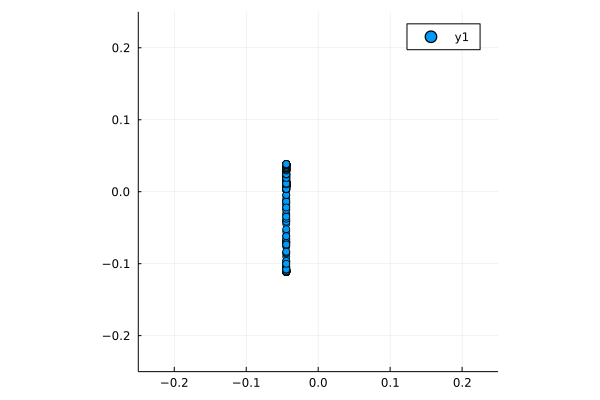

"Eigenvalues Graph"

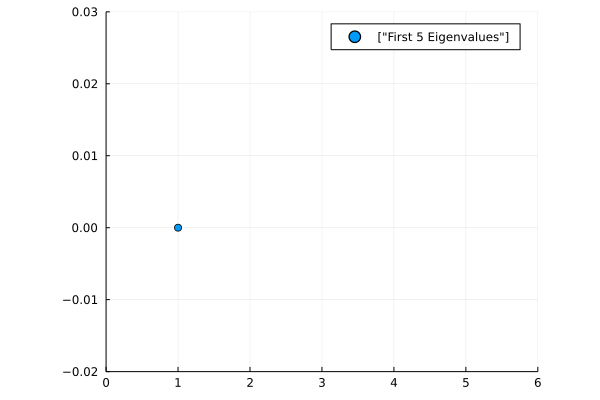

2×2 Matrix{Float64}:
 -0.0443678  -0.0443678
  0.0178426  -0.0968919

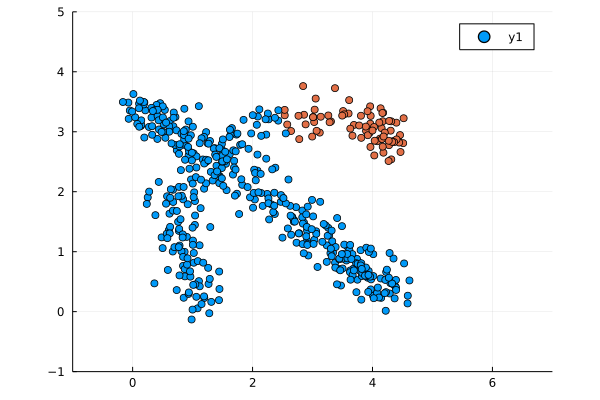

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.729397e-01
      1       1.222307e-01      -5.070900e-02 |        2
      2       1.219313e-01      -2.994237e-04 |        2
      3       1.218195e-01      -1.118329e-04 |        2
      4       1.217699e-01      -4.952317e-05 |        0
      5       1.217699e-01       0.000000e+00 |        0
K-means converged with 5 iterations (objv = 0.12176993067532843)


In [32]:
spectral_clustering_F("./data/communism.csv", 0.3, 2)

"Finished Importing Data\n"

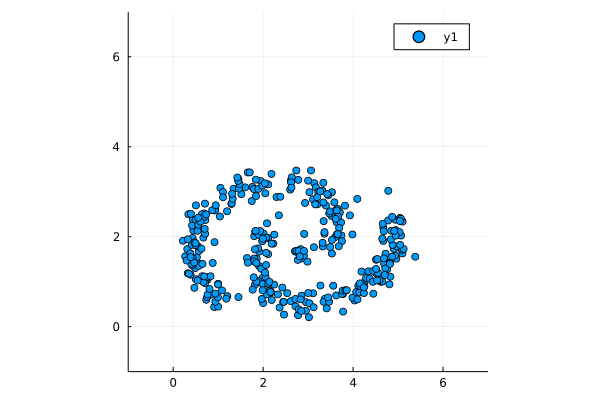

"Laplace Matrix"

20×5 Matrix{Float64}:
  9.30165    -0.957681   -0.150714   -0.447722   -0.640435
 -0.957681    9.27458    -0.250318   -0.58568    -0.585547
 -0.150714   -0.250318    6.95098    -0.709391   -0.117523
 -0.447722   -0.58568    -0.709391   10.3179     -0.463159
 -0.640435   -0.585547   -0.117523   -0.463159   16.0128
 -0.728791   -0.598966   -0.0570244  -0.285571   -0.887133
 -0.550071   -0.69966    -0.662556   -0.979324   -0.488192
 -0.924244   -0.919629   -0.216648   -0.616357   -0.822174
 -0.216667   -0.23975    -0.198952   -0.524223   -0.61256
 -0.396998   -0.468609   -0.417823   -0.844853   -0.668195
 -0.0477736  -0.0330158  -0.0028904  -0.0304728  -0.283153
 -0.66255    -0.558218   -0.067282   -0.324924   -0.9534
 -0.74177    -0.789301   -0.314009   -0.781476   -0.849339
 -0.580246   -0.497341   -0.07217    -0.342306   -0.97532
 -0.381985   -0.345257   -0.0823224  -0.360444   -0.906025
 -0.606925   -0.616026   -0.222274   -0.661833   -0.937713
 -0.111989   -0.0992494  -0.03087    -0.

"Eigenvalues \n"

10-element Vector{Float64}:
 -1.0866809297023494e-14
  0.0895487794655906
  0.20421592550448994
  0.34004531808281424
  0.7217974768128526
  0.7855275686622842
  1.2544557589011656
  1.5223805134018407
  1.952928669844279
  2.105549046344533

"Eigenvectors\n"

20×5 Matrix{Float64}:
 -0.0536056  0.0623113  0.056948    0.00405898   -0.0819378
 -0.0536056  0.0615151  0.0561916   0.00535157   -0.0814259
 -0.0536056  0.0314932  0.0259577   0.0498235    -0.0448133
 -0.0536056  0.0562482  0.0506563   0.0129306    -0.0735181
 -0.0536056  0.0633914  0.0573135   0.00125671   -0.0767849
 -0.0536056  0.0636353  0.057746    0.00116251   -0.0786409
 -0.0536056  0.0574382  0.0519432   0.0112553    -0.0754706
 -0.0536056  0.062191   0.0565701   0.00382816   -0.0794999
 -0.0536056  0.0625653  0.0561226   0.00206374   -0.0733117
 -0.0536056  0.0604377  0.0544655   0.00601271   -0.0749551
 -0.0536056  0.0661136  0.0584905  -0.00530824   -0.0664778
 -0.0536056  0.0637014  0.057665    0.000834374  -0.077437
 -0.0536056  0.0617555  0.0559886   0.00426464   -0.0777861
 -0.0536056  0.0638134  0.0576457   0.000460056  -0.0764282
 -0.0536056  0.0640517  0.0576062  -0.000326721  -0.0743391
 -0.0536056  0.062636   0.0566275   0.00253639   -0.0766418
 -0.0536056  0.0651

"Eigenvectors Graph"

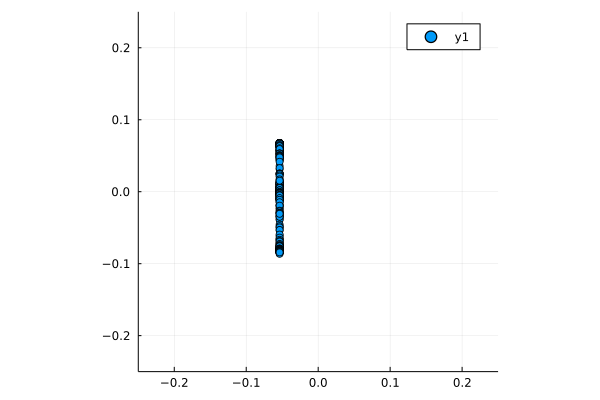

"Eigenvalues Graph"

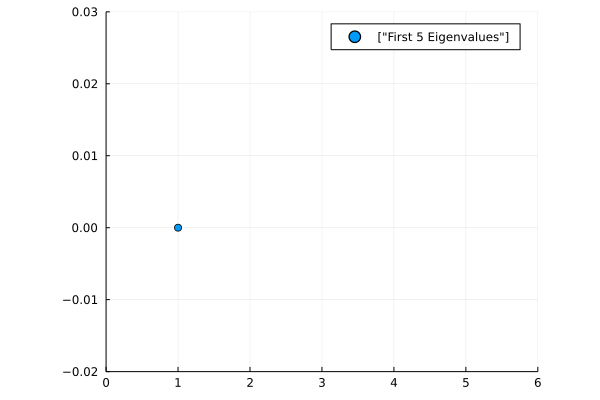

2×2 Matrix{Float64}:
 -0.0536056  -0.0536056
  0.0522835  -0.036906

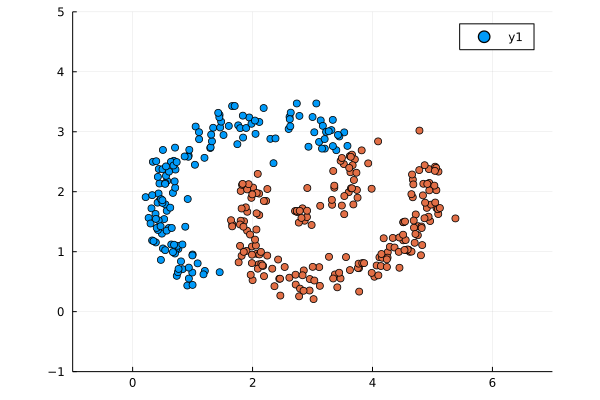

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.834479e-01
      1       3.324872e-01      -2.509606e-01 |        2
      2       3.307601e-01      -1.727145e-03 |        2
      3       3.302129e-01      -5.471756e-04 |        2
      4       3.294068e-01      -8.061252e-04 |        2
      5       3.288421e-01      -5.647139e-04 |        2
      6       3.285696e-01      -2.724569e-04 |        2
      7       3.285324e-01      -3.720207e-05 |        2
      8       3.285088e-01      -2.359275e-05 |        0
      9       3.285088e-01       0.000000e+00 |        0
K-means converged with 9 iterations (objv = 0.32850883275045745)


In [33]:
spectral_clustering_F("./data/moon.csv", 0.3, 2)

"Finished Importing Data\n"

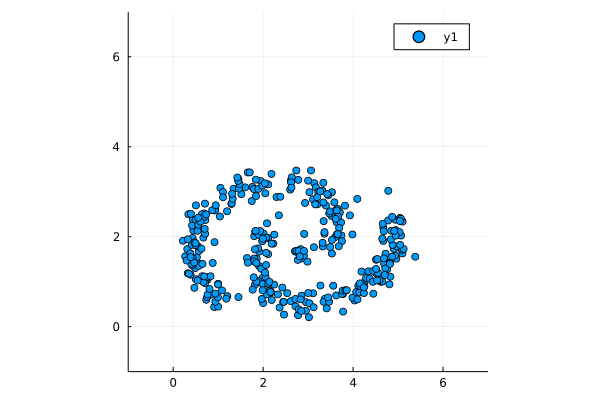

"Similarity Matrix\n"

20×5 Matrix{Float64}:
 0.0  1.0  0.0  1.0  1.0
 1.0  0.0  1.0  1.0  1.0
 0.0  1.0  0.0  1.0  0.0
 1.0  1.0  1.0  0.0  1.0
 1.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0
 0.0  0.0  0.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0
 1.0  1.0  0.0  1.0  1.0
 1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0
 1.0  1.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0

"Laplace Matrix"

20×5 Matrix{Float64}:
 15.0  -1.0   0.0  -1.0  -1.0
 -1.0  15.0  -1.0  -1.0  -1.0
  0.0  -1.0  15.0  -1.0   0.0
 -1.0  -1.0  -1.0  15.0  -1.0
 -1.0  -1.0   0.0   0.0  15.0
 -1.0  -1.0   0.0   0.0  -1.0
 -1.0  -1.0  -1.0  -1.0  -1.0
 -1.0  -1.0   0.0  -1.0  -1.0
  0.0   0.0   0.0  -1.0  -1.0
  0.0  -1.0  -1.0  -1.0  -1.0
  0.0   0.0   0.0   0.0   0.0
 -1.0  -1.0   0.0   0.0  -1.0
 -1.0  -1.0   0.0  -1.0  -1.0
 -1.0   0.0   0.0   0.0  -1.0
  0.0   0.0   0.0   0.0  -1.0
 -1.0  -1.0   0.0  -1.0  -1.0
  0.0   0.0   0.0   0.0  -1.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0  -1.0

"Eigenvalues \n"

10-element Vector{Float64}:
 -4.996003610813204e-16
  0.011012574489625964
  0.044526685850121595
  0.044526685850121595
  0.3659401797361899
  0.5976829230533591
  0.735116300418331
  0.7653625738170584
  1.2642234600300255
  1.342411340349166

"Eigenvectors\n"

20×5 Matrix{Float64}:
 0.0536056  0.0706044  -0.0333797  -0.0333797  0.0819461
 0.0536056  0.0681155  -0.0324878  -0.0324878  0.080358
 0.0536056  0.0331254  -0.0196115  -0.0196115  0.0497288
 0.0536056  0.0681155  -0.0324878  -0.0324878  0.080358
 0.0536056  0.0712154  -0.0335488  -0.0335488  0.0811213
 0.0536056  0.0712409  -0.033547   -0.033547   0.0808813
 0.0536056  0.0681155  -0.0324878  -0.0324878  0.080358
 0.0536056  0.0706044  -0.0333797  -0.0333797  0.0819461
 0.0536056  0.0718458  -0.0336296  -0.0336296  0.0780669
 0.0536056  0.068396   -0.0325312  -0.0325312  0.0791665
 0.0536056  0.0739483  -0.0337516  -0.0337516  0.0648728
 0.0536056  0.0712409  -0.033547   -0.033547   0.0808813
 0.0536056  0.0706044  -0.0333797  -0.0333797  0.0819461
 0.0536056  0.0715414  -0.0336316  -0.0336316  0.0805102
 0.0536056  0.0718822  -0.0336831  -0.0336831  0.0790408
 0.0536056  0.0706044  -0.0333797  -0.0333797  0.0819461
 0.0536056  0.0729199  -0.0338385  -0.0338385  0.074557
 0.0536056  0

"Eigenvectors Graph"

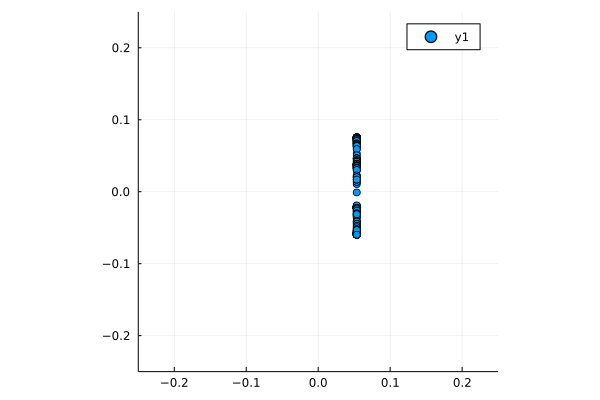

"Eigenvalues Graph"

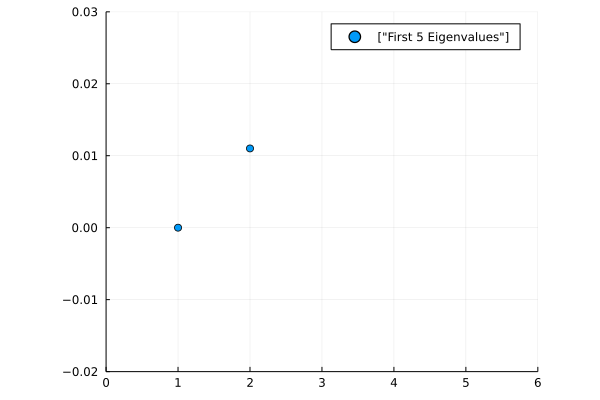

2×2 Matrix{Float64}:
  0.0536056  0.0536056
 -0.0416201  0.0569403

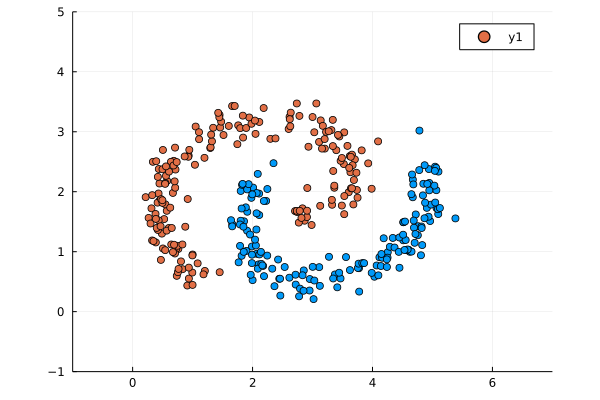

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.178433e-01
      1       1.209484e-01      -9.689493e-02 |        2
      2       1.163576e-01      -4.590723e-03 |        2
      3       1.163293e-01      -2.829582e-05 |        0
      4       1.163293e-01       0.000000e+00 |        0
K-means converged with 4 iterations (objv = 0.11632934185066807)


In [34]:
spectral_clustering_K("./data/moon.csv", 15, 2)